In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
img_src = "../DATASETS/hof/webcam20231103-2.png"

In [5]:
img_path = Path(img_src)
output_path = img_path.with_stem(img_path.stem + '-homography').with_suffix('.txt')



# Setup

In [29]:
from os import PathLike



def render_projection(src, dst, img: PathLike, points = []):
    return render_projection_frame(src, dst, cv2.imread(str(img)), points)

def render_projection_frame(src, dst, frame, points = []):
    x_min = min(dst[:,0])
    if x_min < 0:
        dst[:,0] += x_min * -1
    y_min = min(dst[:,1])
    if y_min < 0:
        dst[:,1] += y_min * -1

    # dst[:,0] +=  1500
    # dst[:,1] +=  600


    # print("from", src)
    # print("to", dst)

    H, status = cv2.findHomography(src,dst)
    f, axes = plt.subplots(1, 2, figsize=(16,8))

    img = frame
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for i, p in enumerate(src):
        cv2.circle(img, p, 3, (0,255,0), 0)
        cv2.putText(img, str(i), p, cv2.FONT_HERSHEY_COMPLEX, .5, (0,255,0))

    # print (H)
    dst = cv2.warpPerspective(img,H,(2500,1920))
    axes[0].imshow(img)
    axes[1].imshow(dst)

    def onclick(event):
        points.append([event.xdata,event.ydata])
    f.canvas.mpl_connect('button_press_event', onclick)

    plt.tight_layout()
    plt.show()
    # display(Image.fromarray(img).resize((600,600)), Image.fromarray(dst).resize((600,600)))
    return H

# First recording

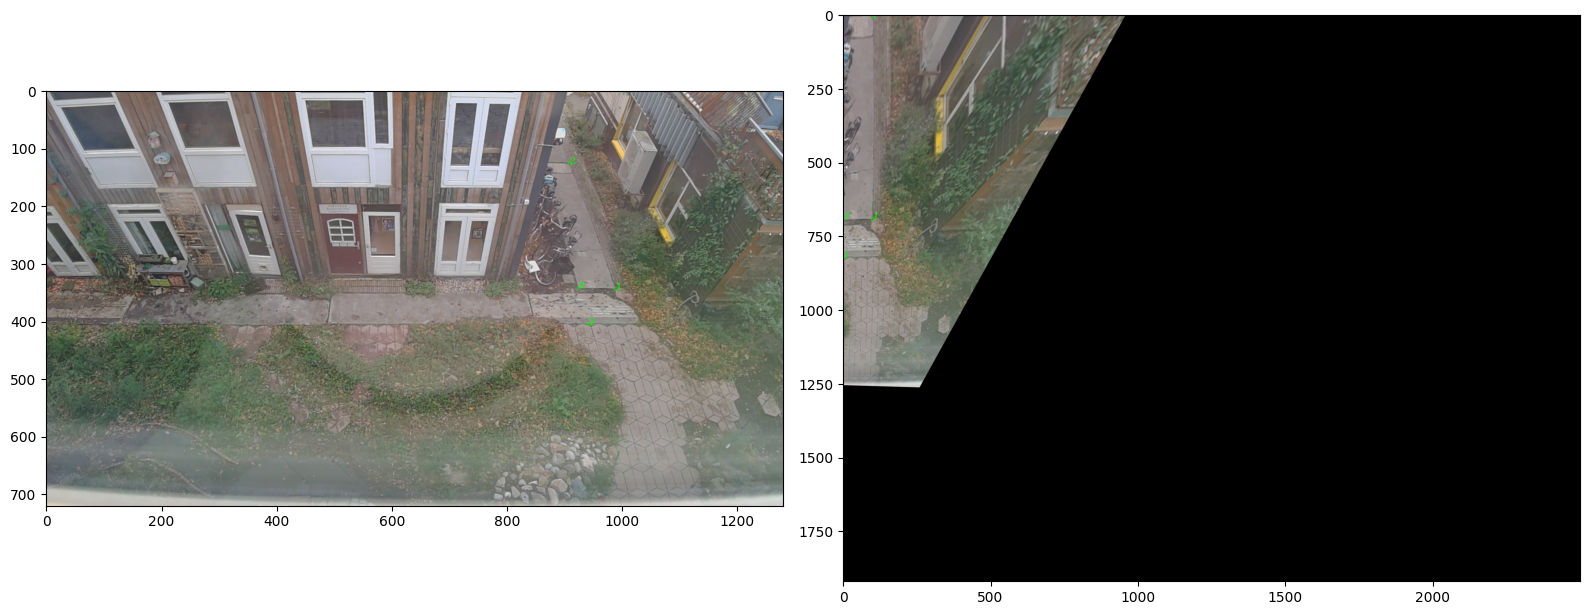

array([[ 2.14811662e+00, -6.24253612e-01, -1.76917928e+03],
       [-3.00384000e-01,  4.54296024e+00, -2.95121358e+02],
       [-2.89572527e-04,  1.97232411e-03,  1.00000000e+00]])

In [7]:

src = np.array([[924, 341],
    [988, 343],
    [908,125],
    [941, 404],])

dst = np.array([[2,0],
[100,0],
[105, -695],
[0, 130]])


render_projection(src, dst, img_path)

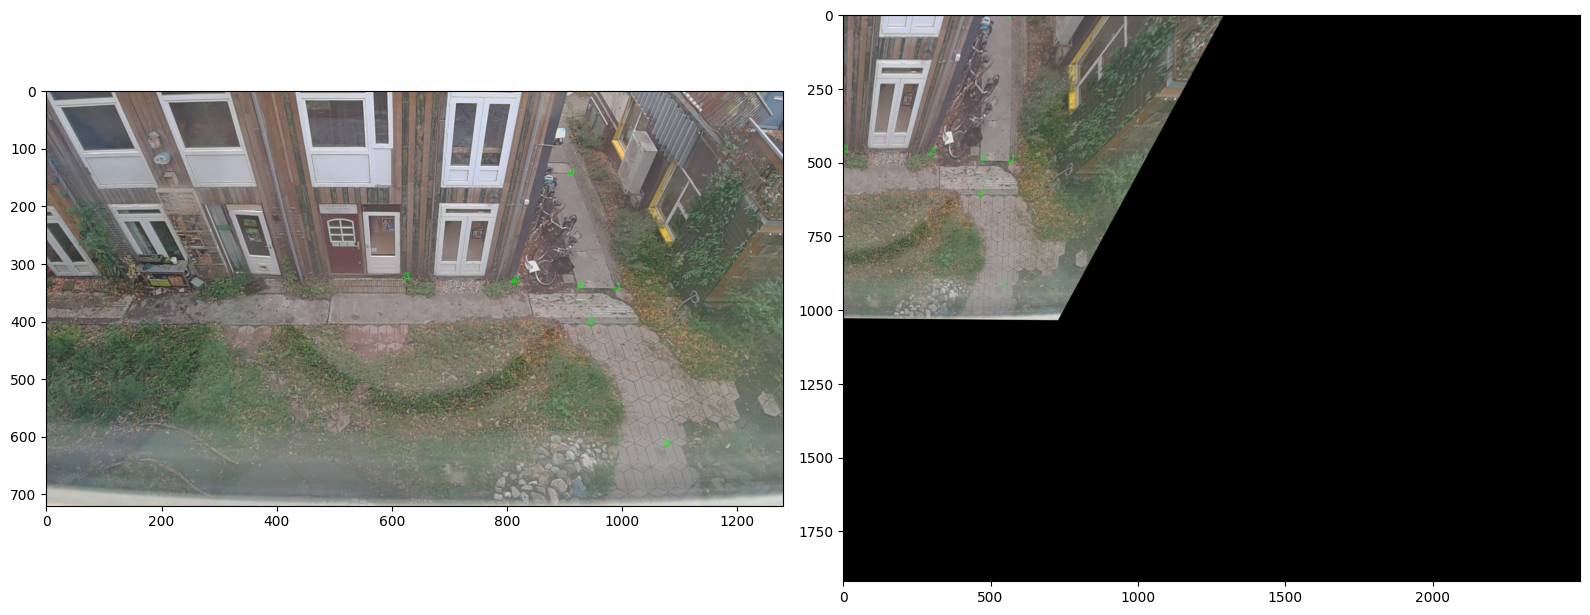

[[ 2.28441941e+00 -7.25403562e-03 -1.41218482e+03]
 [-2.66305397e-02  3.73547277e+00 -5.09931039e+02]
 [-4.62076533e-05  1.56722238e-03  1.00000000e+00]]


In [8]:

src = np.array([[924, 341],
    [988, 343],
    [810, 330],
    [620, 325],
    [908,143],
    [1072,616],
    [941, 404],
    
    ])

dst = np.array([[0,0],
[97,0],
[-160,-33],
[-460,-33],
[105, -500],
[87, 420],
[-2, 112]
], dtype=np.float64)


H = render_projection(src, dst, img_path)
print(H)
# np.savetxt(output_path, H, delimiter=",")
# cv2.imwrite("/tmp/test.jpg", dst)

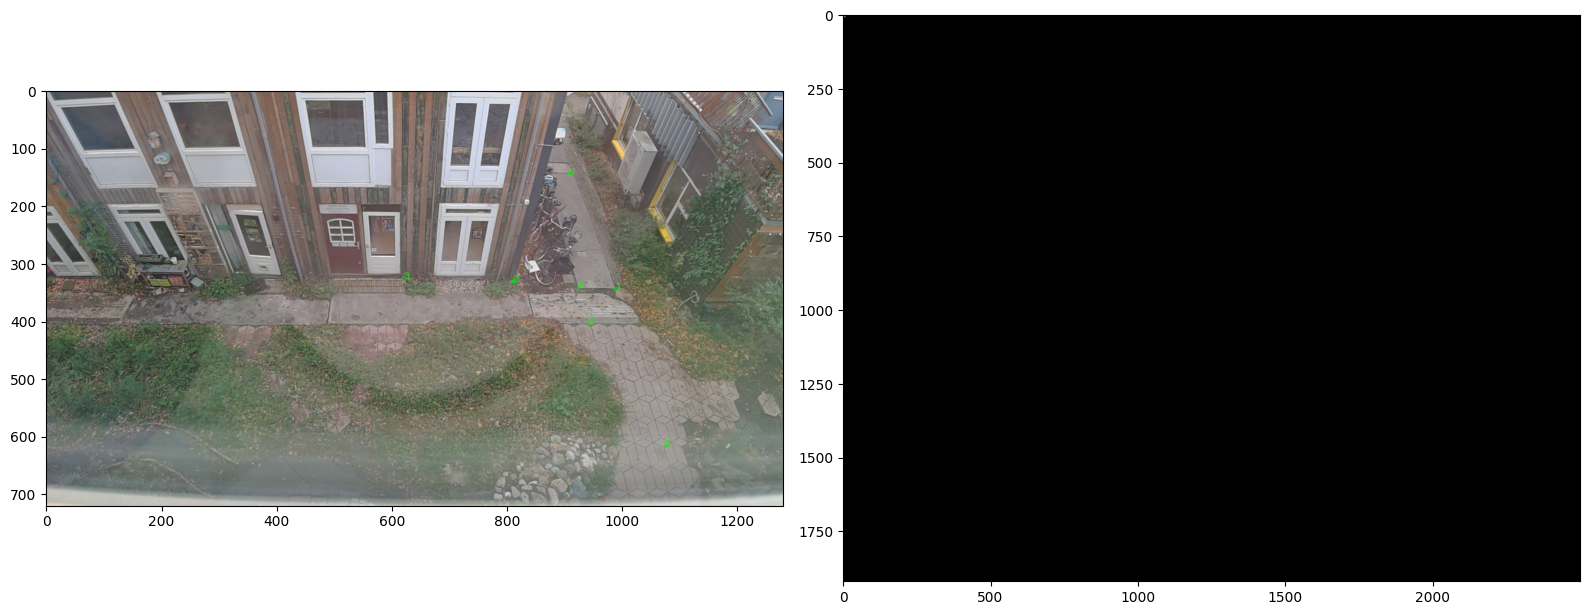

[[ 2.33261071e-02 -7.18489563e-05 -1.44258091e+01]
 [-1.58777686e-04  3.80969604e-02 -5.30388927e+00]
 [-2.36557580e-05  1.59322903e-03  1.00000000e+00]]


In [9]:
scaled_dst = dst / 100
H = render_projection(src, scaled_dst, img_path)
print(H)
# np.savetxt(output_path, H, delimiter=",")


# second recording

In [10]:
img_src = "../DATASETS/hof/webcam20240110.png"
img_path = Path(img_src)
output_path = img_path.with_stem(img_path.stem + '-homography').with_suffix('.txt')

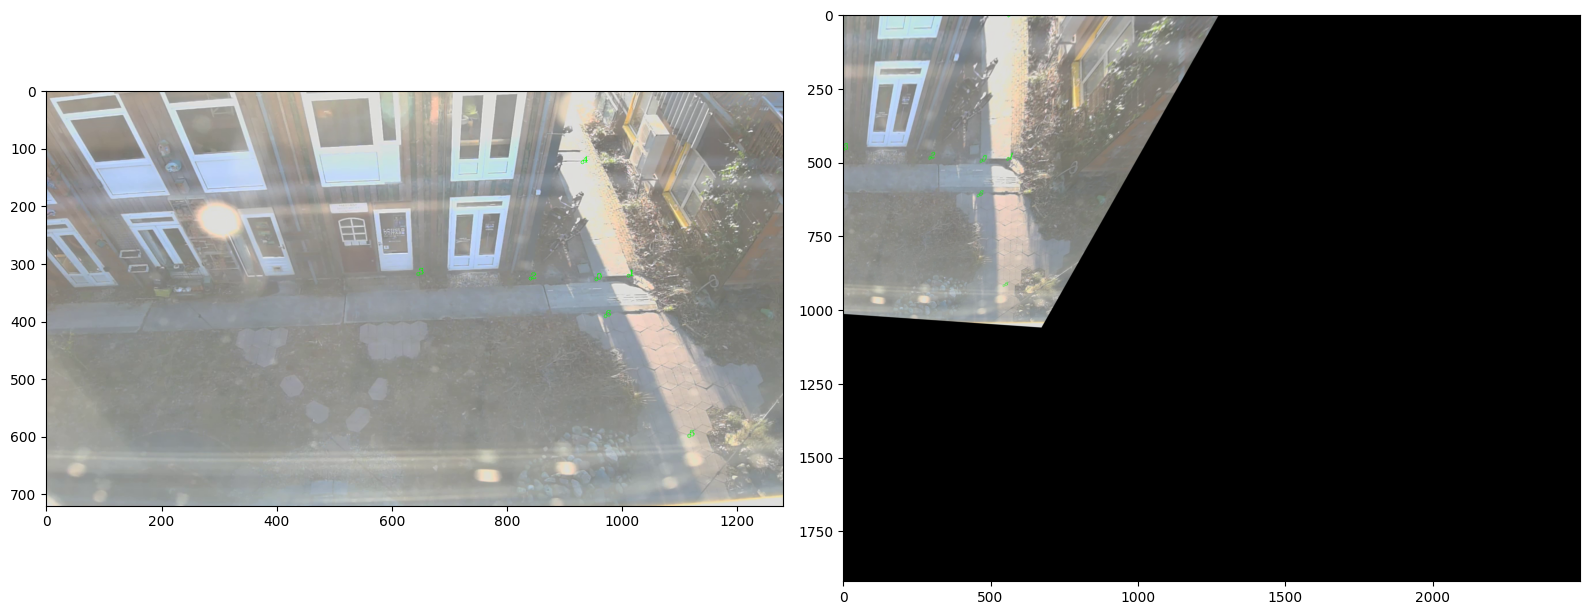

[[ 2.11102794e+00 -9.31080334e-02 -1.32994099e+03]
 [ 6.52086770e-02  3.41420130e+00 -4.80260705e+02]
 [-7.87097747e-05  1.44776415e-03  1.00000000e+00]]


In [11]:

src = np.array([
    [954, 326], # 0
    [1010, 320], # 1
    [840, 325], # 2
    [645, 317], # 3
    [930,123], # 4
    [1115,598], # 5
    [970, 390], # 6
    ])

dst = np.array([[0,0],
[97,0],
[-160,-33],
[-460,-33],
[105, -500],
[87, 420],
[-2, 112]
], dtype=np.float64)

H = render_projection(src, dst, img_path)
print(H)

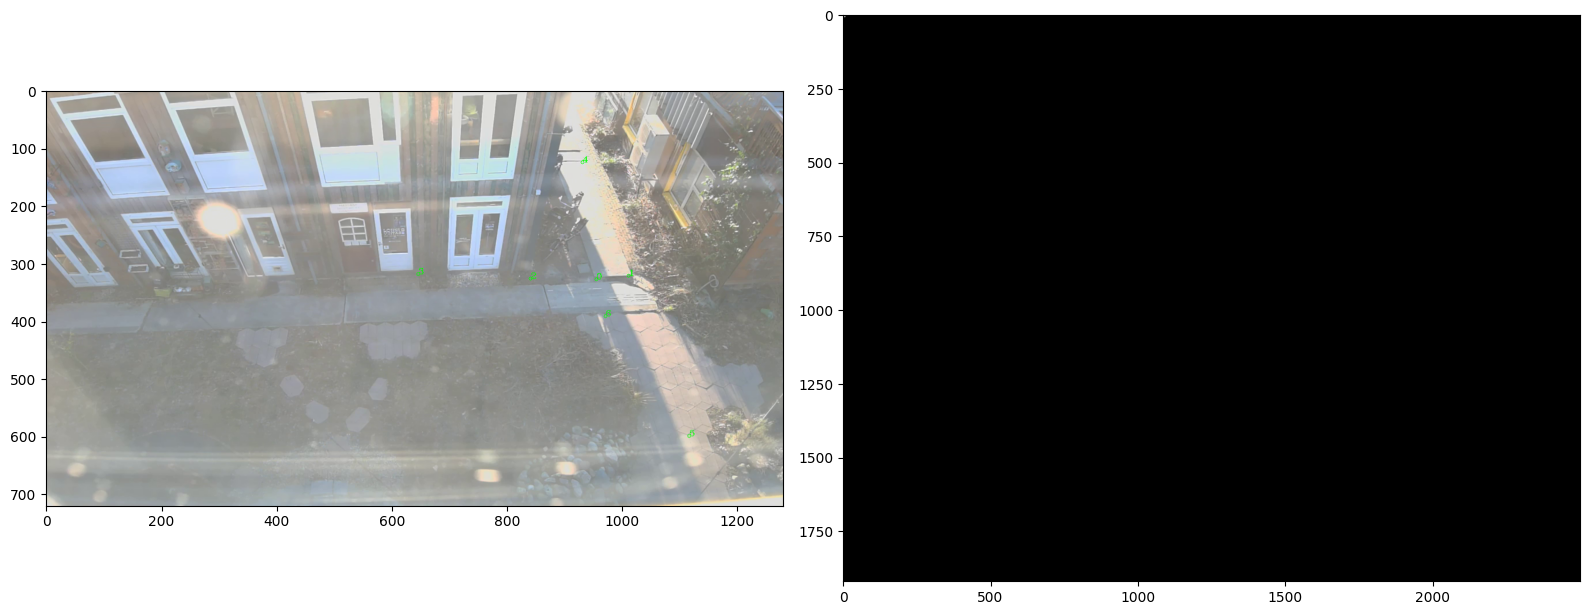

[[ 2.07873681e-02 -9.15620699e-04 -1.30923858e+01]
 [ 5.63969727e-04  3.36566989e-02 -4.66048256e+00]
 [-9.42743714e-05  1.43173299e-03  1.00000000e+00]]
../DATASETS/hof/webcam20240110-homography.txt


In [12]:

scaled_dst = dst / 100

H = render_projection(src, scaled_dst, img_path)
print(H)
print(output_path)
# np.savetxt(output_path, H, delimiter=",")

# Compare

Compare the different input images and homeographies.

In [13]:
# cv2.perspectiveTransform(np.array([[[530, 307.56]]]),H)
coords = cv2.perspectiveTransform(np.array([[[0., 0.], [1280., 0], [0, 720], [1280, 720]]]),H)
xs = coords[0,:,0]
ys = coords[0,:,1]


minx, maxx = min(xs), max(xs)
miny, maxy = min(ys), max(ys)

print(f"{minx} < x < {maxx}")
print(f"{miny} < y < {maxy}")

-13.092385786242692 < x < 15.370183792197755
-4.660482560250155 < y < 10.624264991237176


# Expand to multiple video files

In [24]:
# collect all files
video_paths = list(Path('../DATASETS/hof/').glob("*.m4v"))

In [28]:
for video_path in video_paths:
    print(video_path)
    video = cv2.VideoCapture(str(video_path))
    fps = video.get(cv2.CAP_PROP_FPS)
    target_frame_duration = 1./fps
    if '-' in video_path.stem:
        path_stem = video_path.stem[:video_path.stem.rfind('-')]
    else:
        path_stem = video_path.stem
    path_stem += "-homography"
    homography_path = video_path.with_stem(path_stem).with_suffix('.txt')
    if homography_path.exists():
        #print(f'Found custom homography file! Using {homography_path}')
        video_H = np.loadtxt(homography_path, delimiter=',')
    else:
        print(f"\tNo homography for {video_path}")

    _, frame = video.read()
    render_projection_frame()

../DATASETS/hof/webcam20240110-4.m4v
[[[101 120 129]
  [101 120 129]
  [101 120 129]
  ...
  [122 110 112]
  [121 120 100]
  [123 122 102]]

 [[101 120 129]
  [101 120 129]
  [101 120 129]
  ...
  [122 110 112]
  [121 120 100]
  [123 122 102]]

 [[100 119 128]
  [101 120 129]
  [101 120 129]
  ...
  [128 112 110]
  [128 120 101]
  [130 122 103]]

 ...

 [[172 184 189]
  [172 184 189]
  [172 184 189]
  ...
  [149 203 245]
  [149 203 245]
  [149 203 245]]

 [[172 184 189]
  [172 184 189]
  [172 184 189]
  ...
  [151 203 245]
  [151 203 245]
  [151 203 245]]

 [[172 184 189]
  [172 184 189]
  [172 184 189]
  ...
  [151 203 245]
  [151 203 245]
  [151 203 245]]]
../DATASETS/hof/webcam20231103-4.m4v
[[[172 164 145]
  [172 164 145]
  [166 162 152]
  ...
  [146 125 104]
  [146 125 104]
  [146 125 104]]

 [[172 164 145]
  [172 164 145]
  [166 162 152]
  ...
  [146 125 104]
  [146 125 104]
  [146 125 104]]

 [[172 162 148]
  [172 162 148]
  [168 162 150]
  ...
  [146 125 104]
  [146 125 104]
  